# Verbesserung von Unterscheidung Wasser Himmel 

Problem mit bisherigen Segmentierungsmodellen: Heller Himmel wird als Wasser identifziert weil mit Helligkeit, Kontrast und Struktur Wasser und Himmel ähnlich sind. Deshalb sehen besonders helle oder graue Himmel ohne Struktur für das Modell optisch wie Wasserflächen aus.

Lösungsansatz in Data Augmentation auch zusätzlich mit Helligkeitsverfälschungen arbeiten...
Also Himmel simulieren, der hell oder strukturlos ist, damit das Modell lernt hell von Wasser zu unterscheiden. Wir werden sehen ob das eine Verbesserung bringt -> bzw das Modell weniger Generalisiert in der Hinsicht.

Weiters werden in Test, Train und Validation Dataset auch Bilder ohne Wasserflächen/Überschwemmungen und dafür mit Himmel (weiß, hell, grau oder dunkel) mit "schwarzer"/leeren (alles auf 0) Masken erweitert.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Laden der Daten und Inspizieren der Daten (kopiert)

In [2]:
notebook_title = "unet_differenceskywater_data_augmented_tuner"

In [3]:
%run ./utils/load_data.ipynb

/home/aie3/christina/flood-area-segmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No of images:  290
No of masks:  290
(290, 224, 224, 3)
Loaded 290 images and masks.


# Data augmentation mit Helligkeitsverfälschung

Hier wird nun die Augmentation hinsichtlich Kontrast und Schärfe ergänzt:

In [4]:
# import import_ipynb
# from utils.data_augmentation import augment

# augmented_images, augmented_masks = augment(images, masks)

%run ./utils/data_augmentation_sky_water.ipynb

print("Dataset size before augmentation: ", images.shape[0])
print("Dataset size after augmentation:", augmented_images.shape[0])

Dataset size before augmentation:  290
Dataset size after augmentation: 2900


### Auteilung in Train und Validation Daten
- 70% Training
- 15% Validierung
- 15% Test

In [5]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (2030, 224, 224, 3)
Val:   (435, 224, 224, 3)
Test:  (435, 224, 224, 3)


## Ergänzen der Bilder ohne Wasserflächen

Zuerst laden der Daten 

Total images: 14 – Shape: (14, 224, 224, 3)


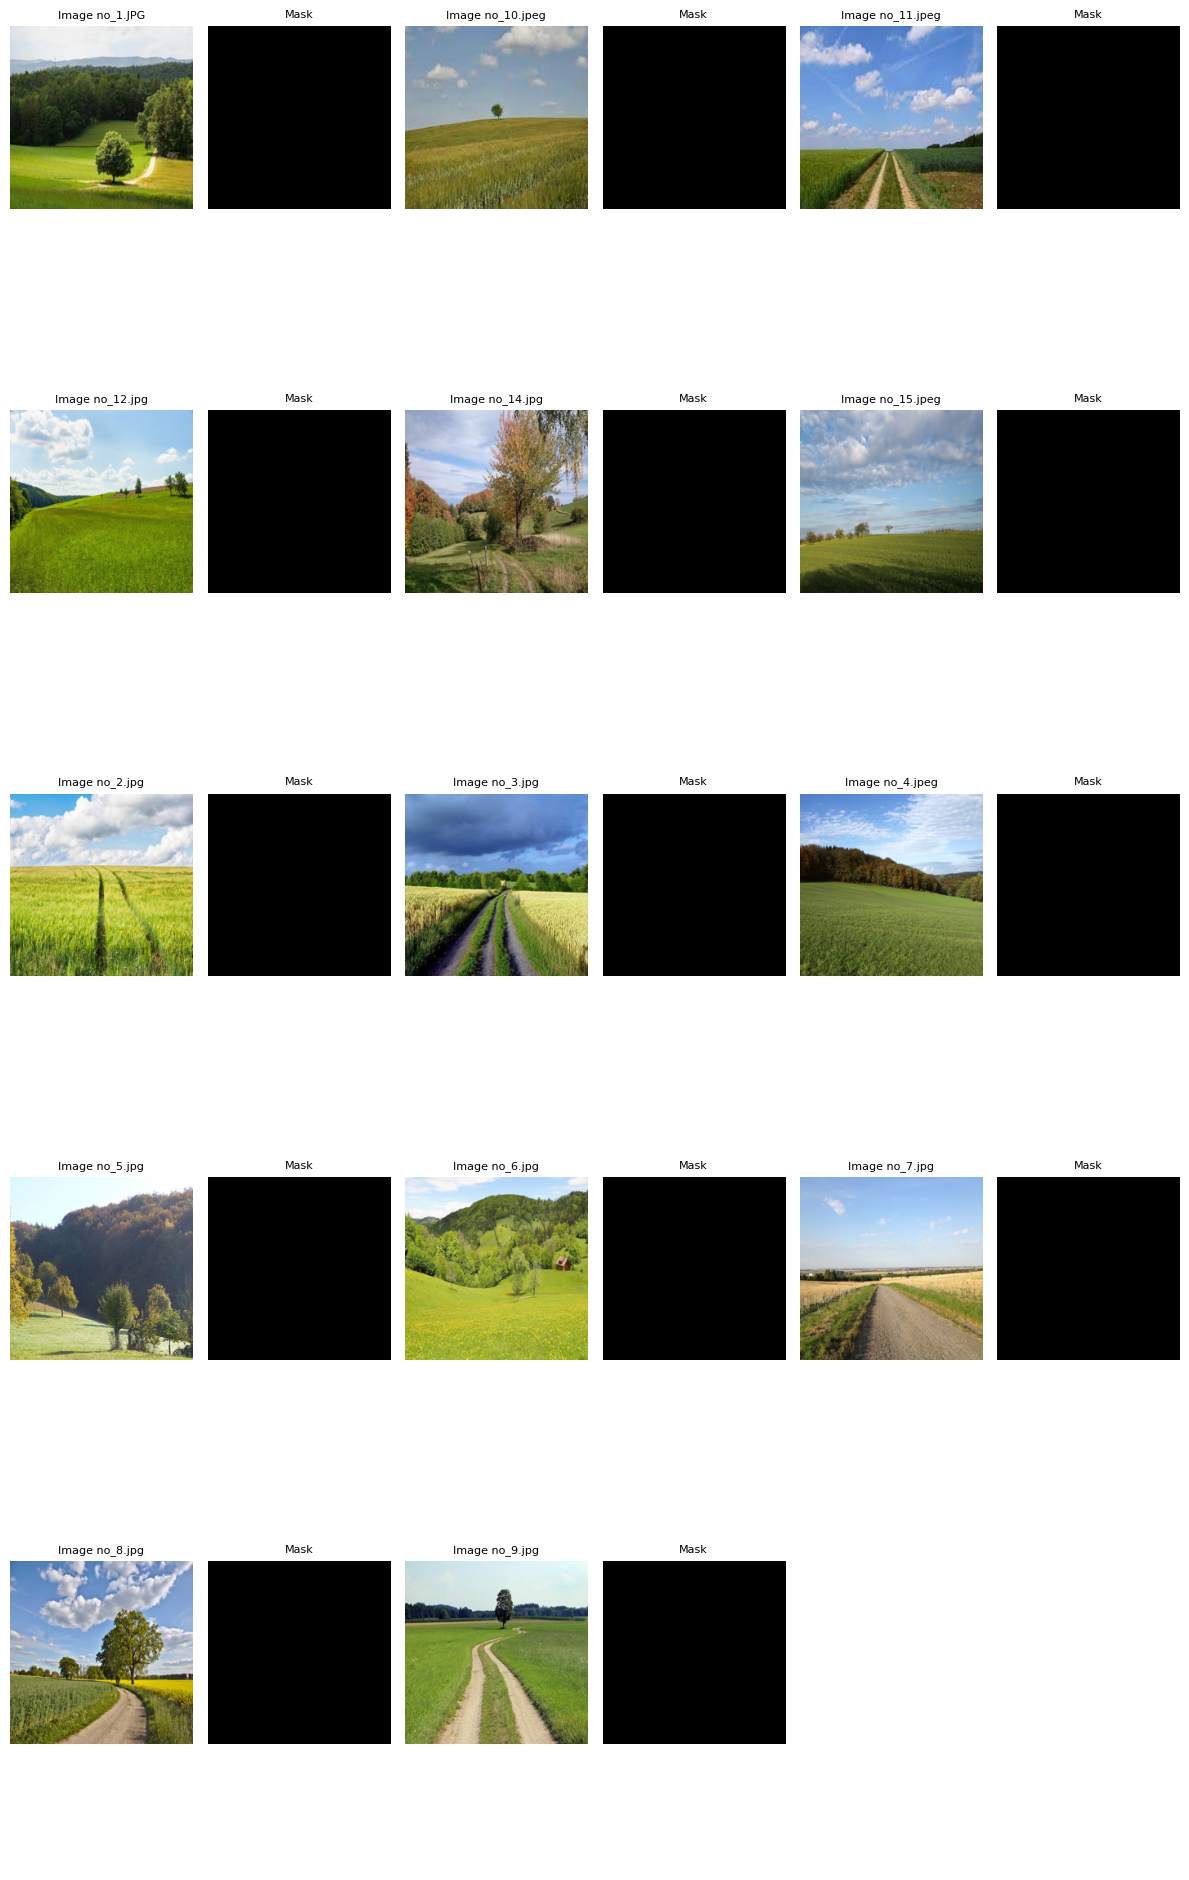

In [6]:
%run ./utils/load_noFlood_data.ipynb

Data Augmentation für no_flood data:

In [7]:
# import import_ipynb
# from utils.data_augmentation import augment

# augmented_images, augmented_masks = augment(images, masks)

%run ./utils/data_augmentation_noFlood_data.ipynb

print("Dataset size before augmentation: ", no_flood_images.shape[0])
print("Dataset size after augmentation:", no_flood_augmented_images.shape[0])

Dataset size before augmentation:  14
Dataset size after augmentation: 140


Verteilung in Train, Test und Validation Data:

In [8]:
from sklearn.model_selection import train_test_split

X_noflood_train, X_noflood_temp, y_noflood_train, y_noflood_temp = train_test_split(
    no_flood_augmented_images, no_flood_augmented_masks, test_size=0.3, random_state=42)

X_noflood_val, X_noflood_test, y_noflood_val, y_noflood_test = train_test_split(
    X_noflood_temp, y_noflood_temp, test_size=0.5, random_state=42)

print("NoFlood Train:", X_noflood_train.shape)
print("NoFlood Val:  ", X_noflood_val.shape)
print("NoFlood Test: ", X_noflood_test.shape)

NoFlood Train: (98, 224, 224, 3)
NoFlood Val:   (21, 224, 224, 3)
NoFlood Test:  (21, 224, 224, 3)


Mit den vorhanden datasets (train, valid, test) kombinieren:

In [9]:
X_train_full = np.concatenate([X_train, X_noflood_train])
y_train_full = np.concatenate([y_train, y_noflood_train])

X_val_full = np.concatenate([X_val, X_noflood_val])
y_val_full = np.concatenate([y_val, y_noflood_val])

X_test_full = np.concatenate([X_test, X_noflood_test])
y_test_full = np.concatenate([y_test, y_noflood_test])

In [10]:
# rename
X_train = X_train_full
y_train = y_train_full

X_val = X_val_full
y_val = y_val_full

X_test = X_test_full
y_test = y_test_full 

# Print dataset shapes
print("flood combined with no_flood:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

flood combined with no_flood:
Train: (2128, 224, 224, 3)
Val:   (456, 224, 224, 3)
Test:  (456, 224, 224, 3)


#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

In [11]:
# limit the usage of GPU memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-06-20 10:21:31.234210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750414891.250131   17600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750414891.254997   17600 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750414891.269722   17600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750414891.269741   17600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750414891.269743   17600 computation_placer.cc:177] computation placer alr

# Model

Tune hyperparameters

In [12]:
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

%run ./utils/u_net_v4_tuner.ipynb

# final_model, best_hps = run_hyperparameter_search(build_unet_model, X_train, y_train, X_val, y_val)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Best val_iou_metric So Far: 0.8095970153808594

Total elapsed time: 00h 31m 48s

## Found best hyperparameters

Best dropout rate: 0.05

Best learning rate: 0.00017976711346215894

Best base filters: 32

Use batch norm: True

In [13]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3), 0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00017976711346215894), loss='binary_crossentropy', metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

I0000 00:00:1750414893.149205   17600 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78344 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]  

 Total params: 1,952,513 (7.45 MB)

 Trainable params: 1,949,697 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [15]:
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50


I0000 00:00:1750414902.584604   19190 service.cc:152] XLA service 0x7f38c8074b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750414902.584679   19190 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-06-20 10:21:42.876993: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750414903.982846   19190 cuda_dnn.cc:529] Loaded cuDNN version 91001


 1/67 ━━━━━━━━━━━━━━━━━━━━ 32:32 30s/step - accuracy: 0.4852 - f1_metric: 0.4687 - iou_metric: 0.3061 - loss: 0.8000 - precision_metric: 0.3862 - recall_metric: 0.5961

I0000 00:00:1750414925.899534   19190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 408ms/step - accuracy: 0.7444 - f1_metric: 0.7286 - iou_metric: 0.5815 - loss: 0.4763 - precision_metric: 0.6911 - recall_metric: 0.7800 - val_accuracy: 0.3551 - val_f1_metric: 0.5190 - val_iou_metric: 0.3606 - val_loss: 2.3227 - val_precision_metric: 0.3606 - val_recall_metric: 0.9333
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8453 - f1_metric: 0.8304 - iou_metric: 0.7106 - loss: 0.3243 - precision_metric: 0.8438 - recall_metric: 0.8200 - val_accuracy: 0.3551 - val_f1_metric: 0.5190 - val_iou_metric: 0.3606 - val_loss: 2.8888 - val_precision_metric: 0.3606 - val_recall_metric: 0.9333
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8505 - f1_metric: 0.8349 - iou_metric: 0.7173 - loss: 0.3050 - precision_metric: 0.8454 - recall_metric: 0.8278 - val_accuracy: 0.3551 - val_f1_metric: 0.5190 - val_iou_metric: 0.3606 - val_loss: 2.9934 - val_precision_metric: 0.3606 - val_recall_metric: 0.9333
Epoch 4/50
67/67 ━━━━━━━━━━━

## Model speichern

In [16]:
model.save(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

# Diagramme

In [17]:
print(history.history.keys())

dict_keys(['accuracy', 'f1_metric', 'iou_metric', 'loss', 'precision_metric', 'recall_metric', 'val_accuracy', 'val_f1_metric', 'val_iou_metric', 'val_loss', 'val_precision_metric', 'val_recall_metric'])


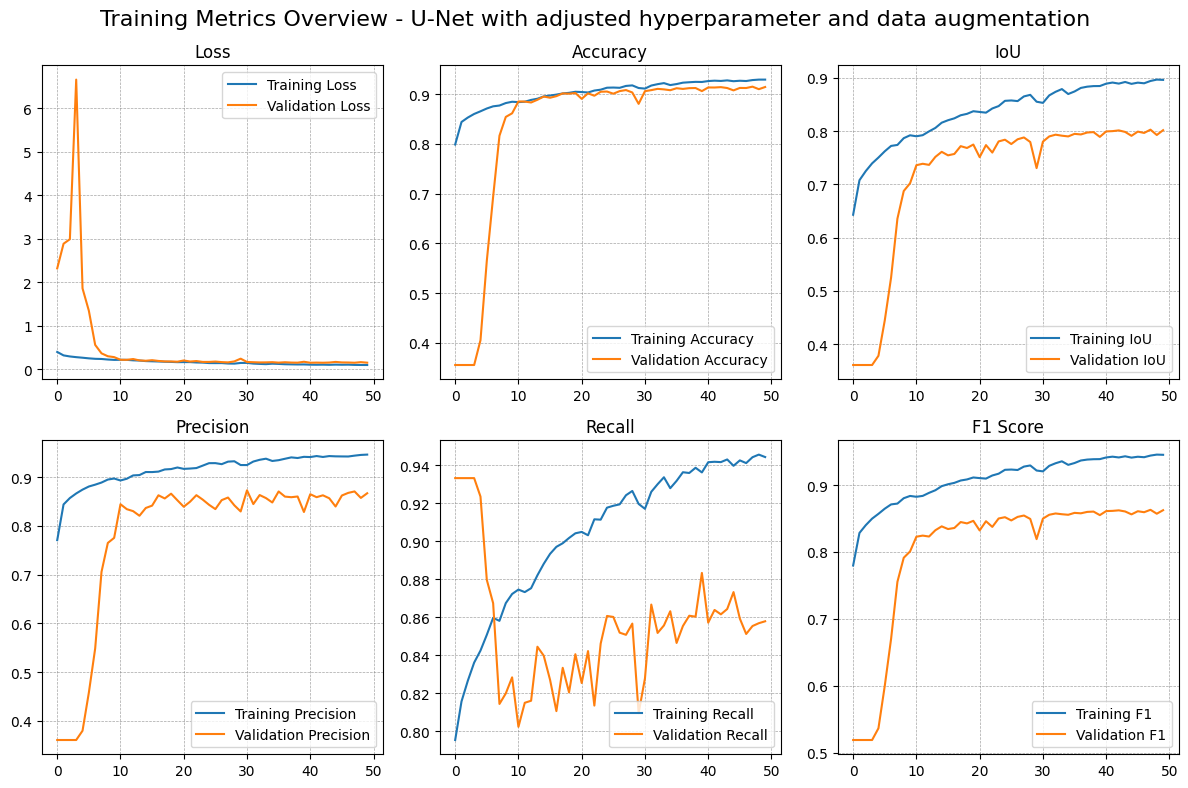

In [18]:
# Plot training history
from datetime import datetime
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color


plt.suptitle('Training Metrics Overview - U-Net with adjusted hyperparameter and data augmentation', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was die Diagramme zeigen:

Das getunte Netz ist bessert als das U-Net v3 Netz.

### Modell evaluieren mit Testdaten

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step

===== Final Test Evaluation =====
Precision: 0.9276
Recall:    0.9213
F1 Score:  0.9245
IoU:       0.8595


#### Vergleich der Metriken für Train, Validation und Test

In [20]:
import import_ipynb
from utils.metrics_barplot import metrics_summary

metrics_summary_results = metrics_summary(history, y_true_flat, y_pred_flat, precision, recall, f1, iou)

print("\n===== Training, Validation und Test Metriken =====")
print(metrics_summary_results.to_string(index=False, float_format="%.4f"))


===== Training, Validation und Test Metriken =====
  Set  Accuracy  Precision  Recall  F1 Score    IoU
Train    0.9296     0.9463  0.9444    0.9451 0.8961
  Val    0.9146     0.8669  0.8579    0.8624 0.8016
 Test    0.9423     0.9276  0.9213    0.9245 0.8595


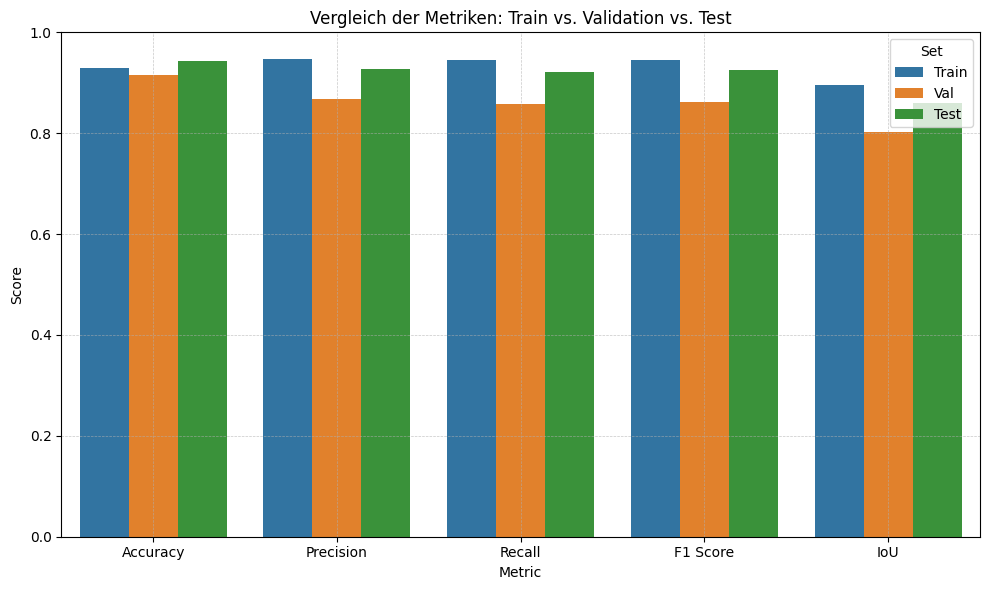

In [21]:
import import_ipynb
from utils.metrics_barplot import draw_metrics_barplot

draw_metrics_barplot(metrics_summary_results, save_title=f"{notebook_title}_batch_size_{BATCH_SIZE}")

# Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


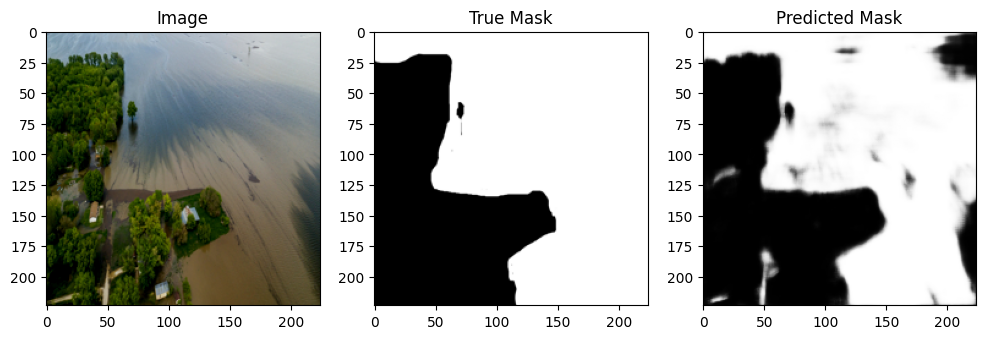

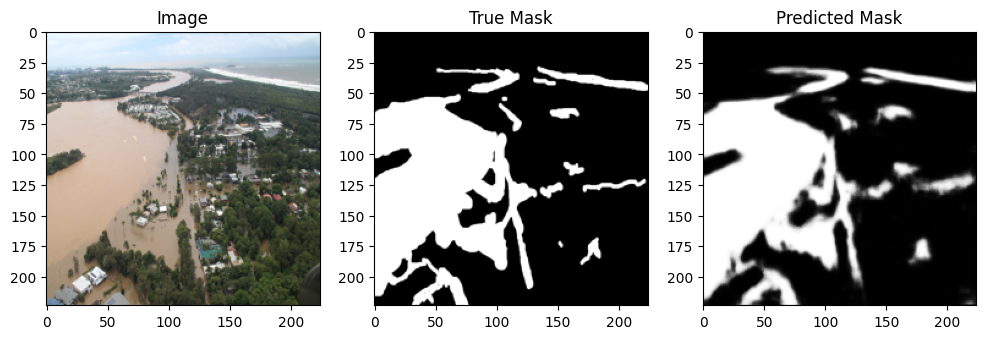

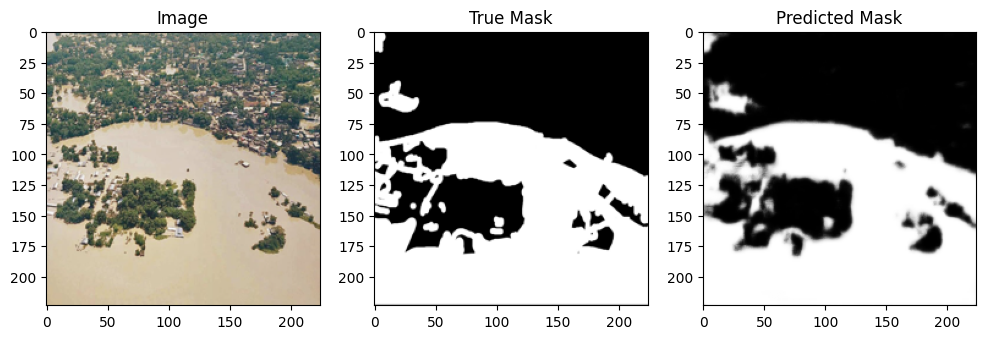

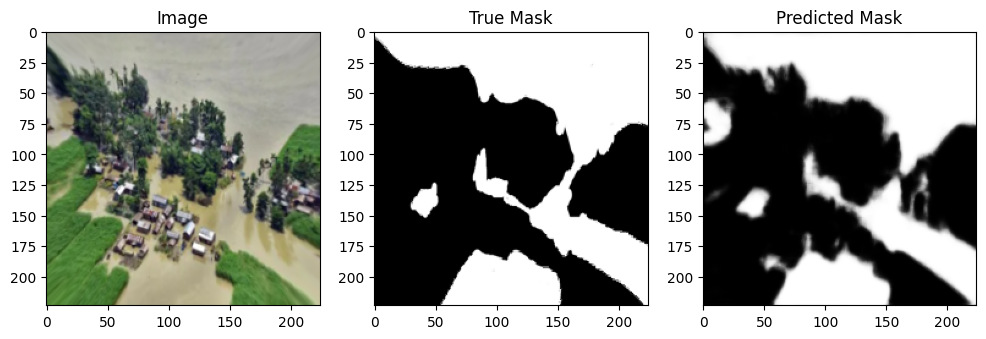

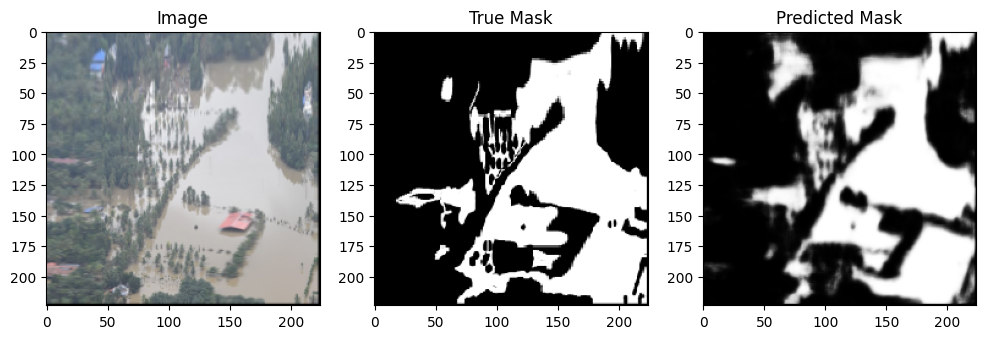

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import load_model

# Imports relevant for loading the model
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric

model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras')

def visualize_predictions(num_images=5):
    preds = model.predict(X_test[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_test[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')


        plt.savefig(f'./img/visualized_predictions/{notebook_title}_batch_size_{BATCH_SIZE}_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
        plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


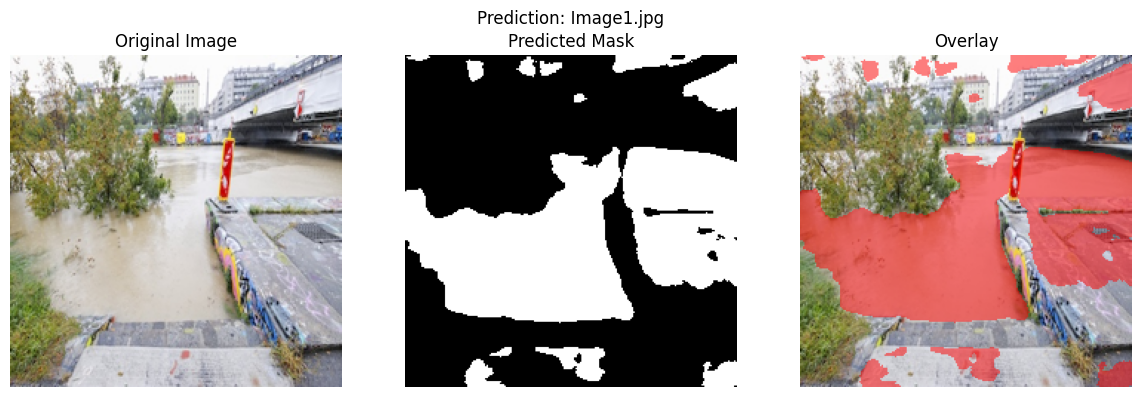

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


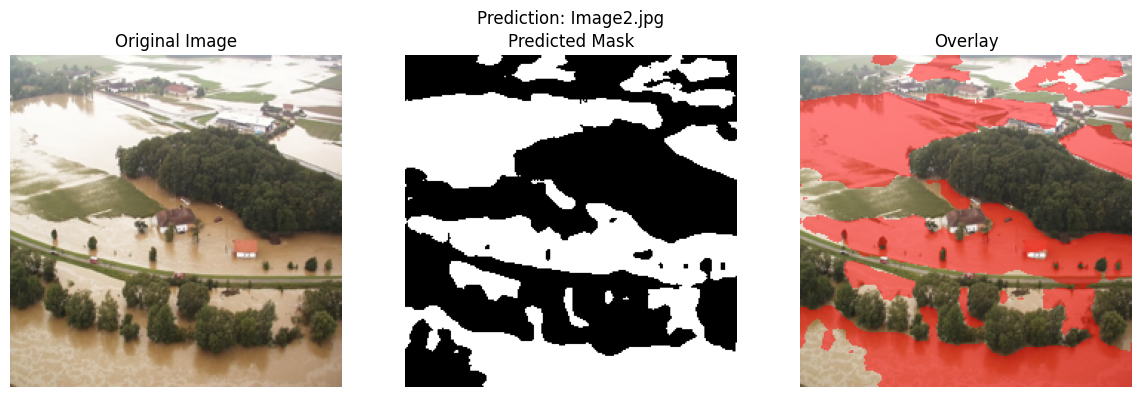

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


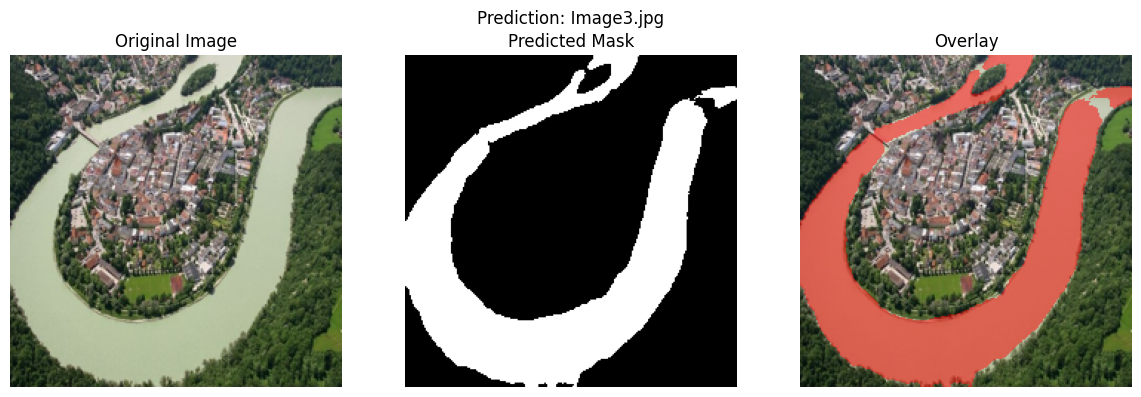

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


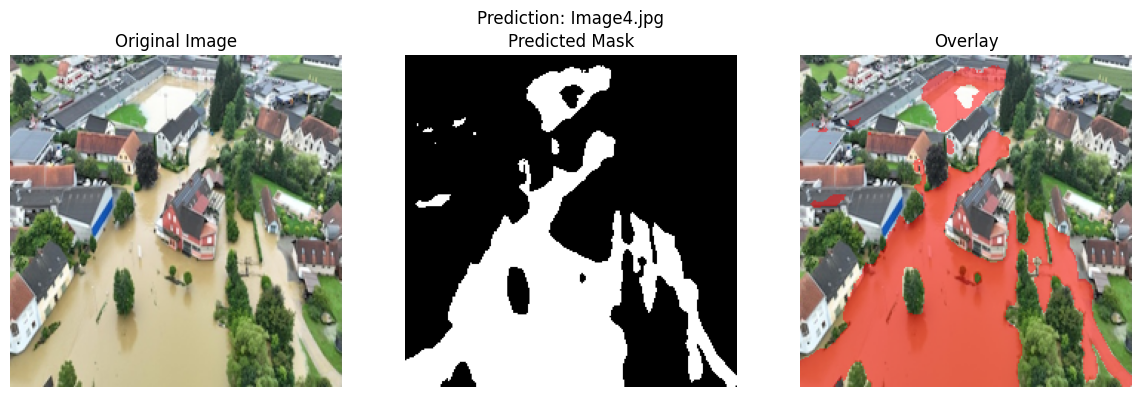

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


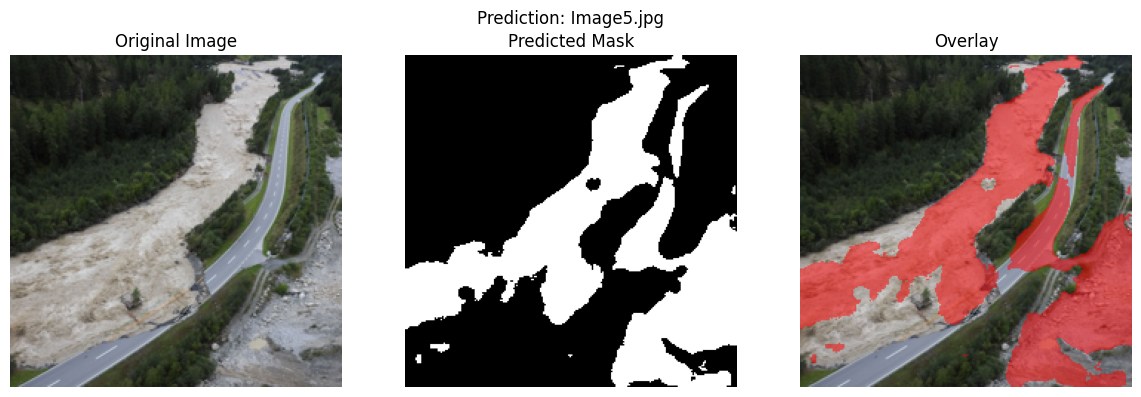

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


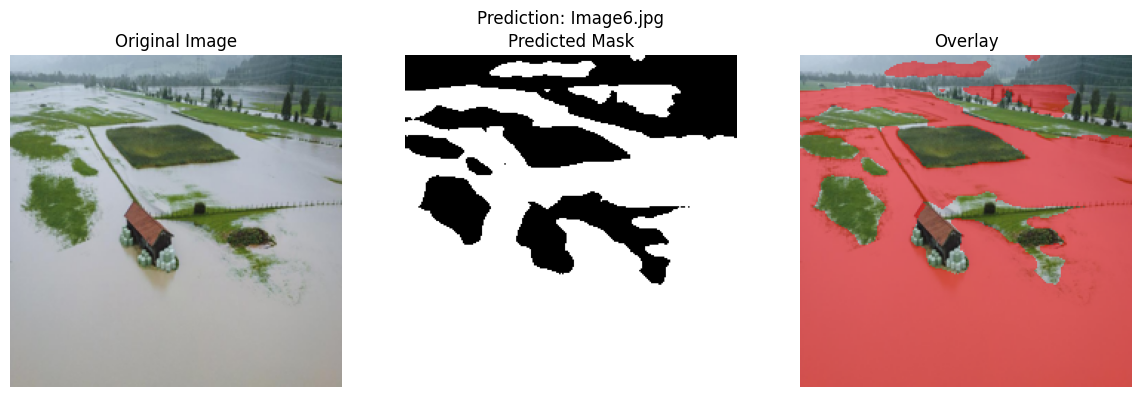

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


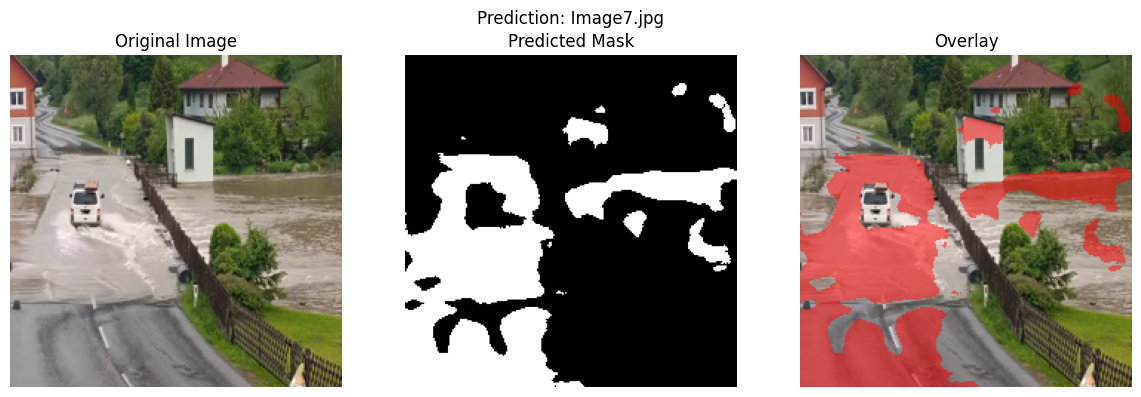

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


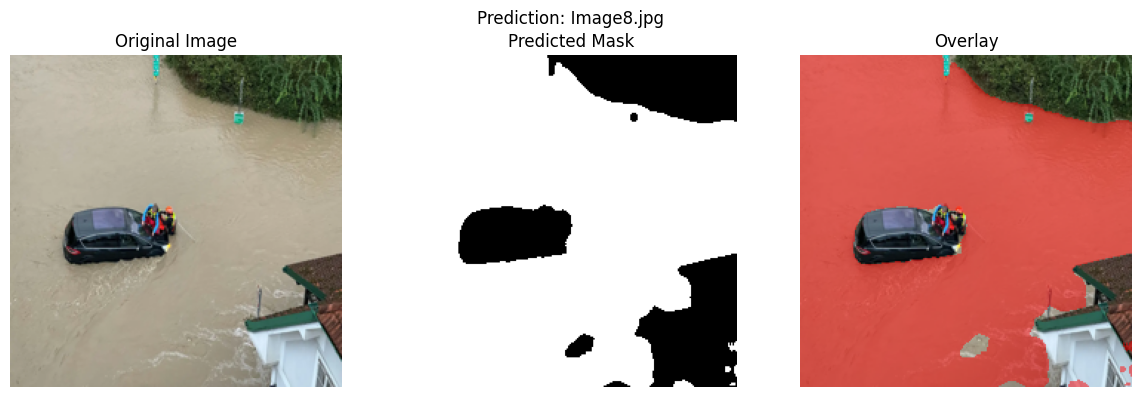

In [23]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model(f'./trained_models/{notebook_title}_batch_size_{BATCH_SIZE}.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
        image_resized=np.array(image_resized), 
        pred_binary=pred_binary, 
        img_file=img_file,
        alpha=ALPHA,
        is_saved=True,
        save_title=f"adjusted_hyperparameter_batch_size_64"
    )